In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

In [3]:
# Solution set for CS 155 Set 6, 2016/2017
# Authors: Fabian Boemer, Sid Murching, Suraj Nair

import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y))

In [4]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20 
reg = 0.1
eps = 0.1
eta = 0.03 # learning rate

Factorizing with  943  users,  1682  movies.


In [5]:
print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
U,V, e_in = train_model(M, N, K, eta, reg, Y_train, eps)
eout = get_err(U, V, Y_test)
print("Ein: ", e_in, " Eout: ", eout)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Epoch 1, E_in (regularized MSE): 0.504333440991
Epoch 2, E_in (regularized MSE): 0.433705106848
Ein:  0.428111953762  Eout:  0.511003967792


In [6]:
A, s, B = np.linalg.svd(V, full_matrices=False)
A_2 = A[:, :2]
A_2_transpose = np.transpose(A_2)
print(A_2_transpose.shape)
U_t = np.dot(A_2_transpose, U.transpose())
print(U_t.shape)
V_t = np.dot(A_2_transpose, V)
print(V_t.shape)

(2, 20)
(2, 943)
(2, 1682)


In [7]:
for i in range(len(U_t)):
    U_t[i] -= np.mean(U_t[i])
    V_t[i] -= np.mean(V_t[i])
    U_t[i] /= np.std(U_t[i])
    V_t[i] /= np.std(V_t[i])

In [8]:
U_vis = np.transpose(U_t)
V_vis = np.transpose(V_t)

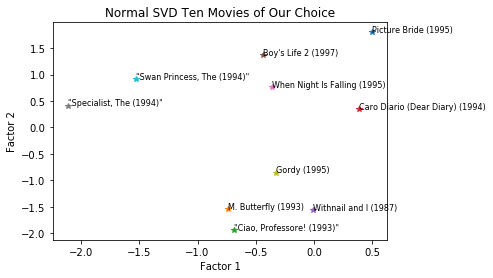

In [13]:
import codecs
movies = [[]]
f = open('data/movies.txt', 'r', encoding='latin1')

for line in f:
    movies.append(line.strip().split('\t')[1])
    
movies = np.array(movies)
movie_idx = [x for x in range(1400, 1410)]
movie_data = V_vis[movie_idx]
movie_names = movies[movie_idx]
for i in range(len(movie_data)):
    plt.plot(movie_data[i][0], movie_data[i][1], '*')
    plt.annotate(movie_names[i], (movie_data[i][0], movie_data[i][1]), fontsize=8)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Ten Movies of Our Choice')
plt.show()

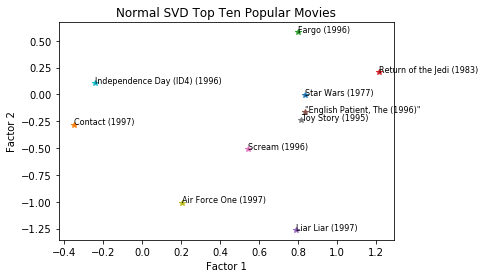

In [14]:
data = np.loadtxt('data/data.txt', delimiter='\t')
num_ratings = np.array([0] * 1683)
num_ratings[0] = 1

for i in range(len(data)):
    num_ratings[(int) (data[i, 1])] += 1
    
most_pop = num_ratings.argsort()[-10:][::-1]
movie_data2 = V_vis[most_pop]
movie_names2 = movies[most_pop]
for i in range(len(movie_data2)):
    plt.plot(movie_data2[i][0], movie_data2[i][1], '*')
    plt.annotate(movie_names2[i], (movie_data2[i][0], movie_data2[i][1]), fontsize=8)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Top Ten Popular Movies')
plt.show()

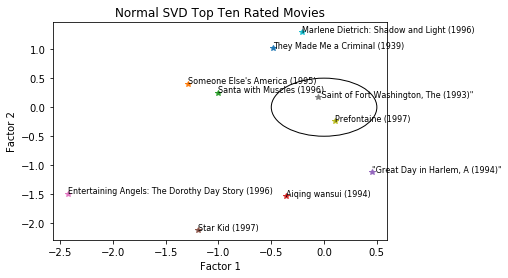

In [23]:
total_rating = np.array([0] * 1683)

for i in range(len(data)):
    total_rating[(int) (data[i, 1])] += (int) (data[i, 2])

avg_rating = total_rating / num_ratings
    
highest_rated = avg_rating.argsort()[-10:][::-1]
movie_data3 = V_vis[highest_rated]
movie_names3 = movies[highest_rated]
for i in range(len(movie_data3)):
    plt.plot(movie_data3[i][0], movie_data3[i][1], '*')
    plt.annotate(movie_names3[i], (movie_data3[i][0], movie_data3[i][1]), fontsize=8)
ax = plt.gca()
circle = plt.Circle((0, 0), 0.5, fill=False)
ax.add_artist(circle)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Top Ten Rated Movies')
plt.show()

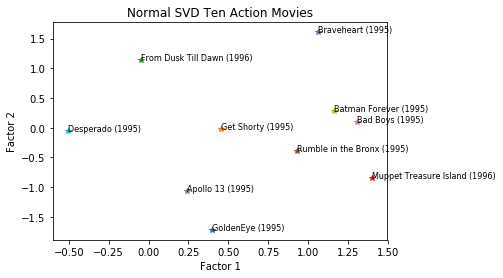

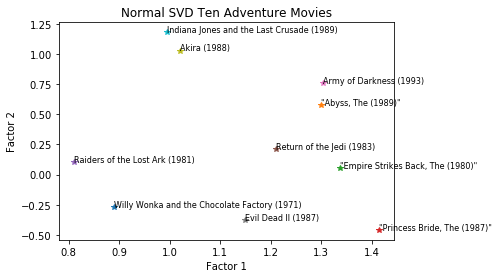

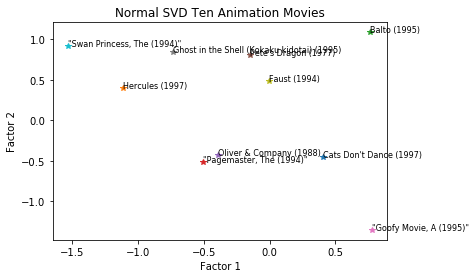

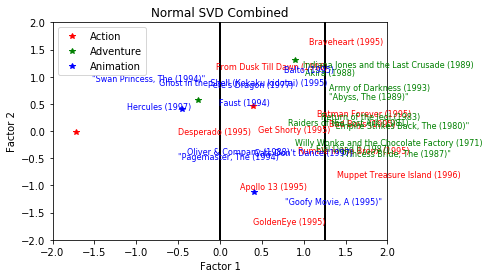

In [22]:
movie_list = [[]]
f = open('data/movies.txt', 'r', encoding='latin1')
for line in f:
    movie_list.append(line.strip().split('\t'))
movie_list = np.array(movie_list)

action_movies = []
adventure_movies = []
animation_movies = []
for i in range(len(movie_list)-1):
    if movie_list[i+1][3]=='1':
        action_movies.append(i+1)
    if movie_list[i+1][4]=='1':
        adventure_movies.append(i+1)
    if movie_list[i+1][5]=='1':
        animation_movies.append(i+1)
slice_action = action_movies[:10]
slice_adventure = adventure_movies[20:30]
slice_animation = animation_movies[30:40]

action_data = V_vis[slice_action]
adventure_data = V_vis[slice_adventure]
animation_data = V_vis[slice_animation]
action_names = movies[slice_action]
adventure_names = movies[slice_adventure]
animation_names = movies[slice_animation]

for i in range(len(action_data)):
    plt.plot(action_data[i][0], action_data[i][1], '*')
    plt.annotate(action_names[i], (action_data[i][0], action_data[i][1]), fontsize=8)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Ten Action Movies')
plt.show()
for i in range(len(adventure_data)):
    plt.plot(adventure_data[i][0], adventure_data[i][1], '*')
    plt.annotate(adventure_names[i], (adventure_data[i][0], adventure_data[i][1]), fontsize=8)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Ten Adventure Movies')
plt.show()
for i in range(len(animation_data)):
    plt.plot(animation_data[i][0], animation_data[i][1], '*')
    plt.annotate(animation_names[i], (animation_data[i][0], animation_data[i][1]), fontsize=8)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Ten Animation Movies')
plt.show()



fig, ax = plt.subplots()
ax.plot(action_data[:][0], action_data[:][1], '*', color='red', label='Action')
ax.plot(adventure_data[:][0], adventure_data[:][1], '*', color='green', label='Adventure')
ax.plot(animation_data[:][0], animation_data[:][1], '*', color='blue', label='Animation')
for i in range(len(action_data)):
    ax.annotate(action_names[i], (action_data[i][0], action_data[i][1]), fontsize=8, color='red')
for i in range(len(adventure_data)):
    ax.annotate(adventure_names[i], (adventure_data[i][0], adventure_data[i][1]), fontsize=8, color='green')
for i in range(len(animation_data)):
    ax.annotate(animation_names[i], (animation_data[i][0], animation_data[i][1]), fontsize=8, color='blue')
plt.plot([1.25, 1.25], [-2, 2], 'k-', lw=2)
plt.plot([0, 0], [-2, 2], 'k-', lw=2)
plt.xlim(left=-2, right=2)
plt.ylim(top=2, bottom=-2)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Normal SVD Combined')
plt.legend()
plt.show()